In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/iris/config.py:139: UserWarning: Ignoring config item 'Resources':'test_data_dir' (section:option) as '/home/h05/itwl/projects/git/iris-test-data/test_data' is not a valid directory path.
  warnings.warn(msg.format(section, option, c_path))


### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_dtr = np.vstack([create_predictdand_data(file)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
dtr_truth = Y_test["diurnal_temperature_range"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_dtr = y_train_dtr[~nan_train_mask]
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
dtr_truth = dtr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

### Prepare model

In [7]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [8]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_dtr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [9]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 958646.52903118
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.73041685,   0.64269484,   4.8959766 ,  -3.87722946,
         4.36627413,  -3.32058914,  -2.23986122,   3.87125389,
        -0.26731177,  -7.26258146,  -0.52830405,  12.81094835,
         0.07416973,  -0.35123253,  -7.21157883,   3.34909139,
       -24.96108781,   7.14311523])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 369
      nit: 304
   status: 0
  success: True
        x: array([10.08500914,  1.25889584,  0.32994974, -4.51723461,  0.34349161,
       -2.73654291, -2.59383459, -4.82184951,  0.66107275, -3.28086112,
       -2.32281819, -2.51703631, 11.11622268, 12.14911117, -0.34815046,
       -3.59310273, -2.84288199, -0.09535695])

### Predict on testing set

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(dtr_truth[35], posterior_dtr_data[35])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[85], posterior_dtr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:41], posterior_dtr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], posterior_dtr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], posterior_dtr_data[35:]).mean()}")

RMSE at 2050: 0.1355563637537149
RMSE at 2100: 0.13756412119347455
RMSE 2045-2055: 0.1381965797189978
RMSE 2090-2100: 0.15830919758363085
RMSE 2050-2100: 0.14989552025108122


[Text(0.5, 1.0, 'Difference')]

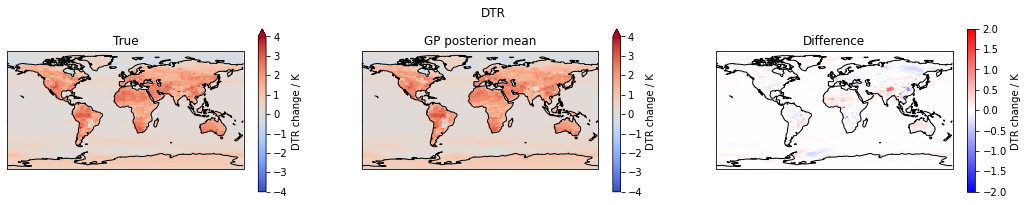

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Really just CO2 (1.54) 

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.09535695]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.5088506517929094
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,10.085050837425499
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.01085999397292445
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.8716691199869082
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.03690637217789787
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.87956936, 0.06278131, 0.07207218..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.02714115693921913
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.09348763, 0.07760752, 11.11623755..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.056624712565659326


In [16]:
# Save predictions
posterior_dtr_data.to_netcdf('climatebench-gp-posterior-mean-dtr-test-2019-2100.nc')
posterior_dtr_std_data.to_netcdf('climatebench-gp-posterior-std-dtr-test-2019-2100.nc')